## Import lib

In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder


# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

# Pytorch way of data augmentation.
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split


import albumentations as A
from albumentations.pytorch import ToTensorV2
! pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.5 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Create dataframe

In [2]:
df = pd.read_csv('/kaggle/input/flood-area-segmentation/metadata.csv')
df['Image'] = [os.path.join('/kaggle/input/flood-area-segmentation/Image', i) for i in df['Image']]
df['Mask'] = [os.path.join('/kaggle/input/flood-area-segmentation/Mask', i) for i in df['Mask']]
df.head()

,Image,Mask
0,/kaggle/input/flood-area-segmentation/Image/0.jpg,/kaggle/input/flood-area-segmentation/Mask/0.png
1,/kaggle/input/flood-area-segmentation/Image/1.jpg,/kaggle/input/flood-area-segmentation/Mask/1.png
2,/kaggle/input/flood-area-segmentation/Image/2.jpg,/kaggle/input/flood-area-segmentation/Mask/2.png
3,/kaggle/input/flood-area-segmentation/Image/3.jpg,/kaggle/input/flood-area-segmentation/Mask/3.png
4,/kaggle/input/flood-area-segmentation/Image/4.jpg,/kaggle/input/flood-area-segmentation/Mask/4.png


## Show images

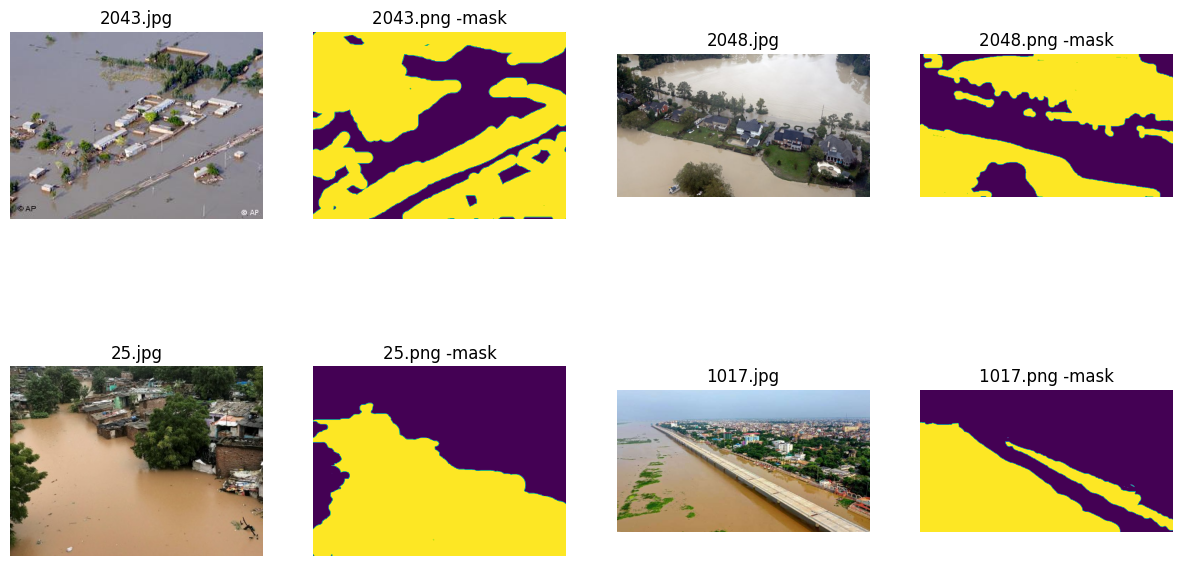

In [3]:
show_imgs = 4
idx = np.random.choice(len(df), show_imgs, replace=False)
fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    new_i = i//2
    if i % 2 ==0 :
        full_path = df.loc[idx[new_i]]['Image']
        basename = os.path.basename(full_path) 
    else:
        full_path = df.loc[idx[new_i]]['Mask']
        basename = os.path.basename(full_path) + ' -mask' 
    ax.imshow(plt.imread(full_path))
    ax.set_title(basename)
    ax.set_axis_off()

## Create datasets and dataloaders

In [4]:
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
    # A.Normalize(p=1.0),
    # ToTensorV2(),
    ]
    , is_check_shapes = False
)

test_transforms = A.Compose([
    A.Resize(512, 512),
    # ToTensorV2(),
    ],
    is_check_shapes = False
)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = np.array(Image.open(self.df.iloc[index]['Image']).convert('RGB'))
        mask = np.array(Image.open(self.df.iloc[index]['Mask']).convert('L'))
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        # print(f'img.shape : {img.shape}')
        # print(f'mask.shape : {mask.shape}')
        sample = {'x': img, 'y': target}
        return sample


In [5]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_df, val_df = train_test_split(df, test_size=0.2,random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
print(f'len train: {len(train_df)}')
print(f'len val: {len(val_df)}')

len train: 232
len val: 58


## Create model

In [6]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model(torch.randn((1,3,512,512))).shape


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 297MB/s]


torch.Size([1, 1, 512, 512])

## Training and validation

In [7]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, batch in enumerate(dataloader):
        x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        # print(f'train_acc: {acc}')
        epoch_iou_score += iou_score
        lr_scheduler.step()
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches



def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloader):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            # print(f'val_acc: {acc}')
            epoch_iou_score += iou_score
            # size += y.shape[0]
    return epoch_loss/num_batches, epoch_iou_score/num_batches

In [8]:
EPOCHS = 50
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
 
loss_fn = smp.losses.DiceLoss(mode="binary")

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 200, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    
    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')

    # On epoch end
    torch.save(model.state_dict(), "checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.2891, val_loss: 0.7501     train_iou_score: 0.618, val_iou_score: 0.129     lr: 0.001


  2%|▏         | 1/50 [00:29<23:46, 29.12s/it]

EPOCH: 002     train_loss: 0.2075, val_loss: 0.4655     train_iou_score: 0.673, val_iou_score: 0.379     lr: 0.001


  4%|▍         | 2/50 [00:51<20:18, 25.39s/it]

EPOCH: 003     train_loss: 0.1995, val_loss: 0.1902     train_iou_score: 0.679, val_iou_score: 0.690     lr: 0.001


  6%|▌         | 3/50 [01:14<18:56, 24.18s/it]

EPOCH: 004     train_loss: 0.1952, val_loss: 0.1712     train_iou_score: 0.684, val_iou_score: 0.715     lr: 0.0001


  8%|▊         | 4/50 [01:37<18:05, 23.61s/it]

EPOCH: 005     train_loss: 0.1794, val_loss: 0.1605     train_iou_score: 0.704, val_iou_score: 0.730     lr: 0.0001


 10%|█         | 5/50 [01:59<17:24, 23.22s/it]

EPOCH: 006     train_loss: 0.1685, val_loss: 0.1678     train_iou_score: 0.721, val_iou_score: 0.721     lr: 0.0001


 12%|█▏        | 6/50 [02:22<16:47, 22.90s/it]

EPOCH: 007     train_loss: 0.1757, val_loss: 0.1606     train_iou_score: 0.711, val_iou_score: 0.730     lr: 1e-05


 14%|█▍        | 7/50 [02:44<16:16, 22.70s/it]

EPOCH: 008     train_loss: 0.1755, val_loss: 0.1511     train_iou_score: 0.712, val_iou_score: 0.743     lr: 1e-05


 16%|█▌        | 8/50 [03:07<15:51, 22.65s/it]

EPOCH: 009     train_loss: 0.1712, val_loss: 0.1566     train_iou_score: 0.716, val_iou_score: 0.736     lr: 1e-05


 18%|█▊        | 9/50 [03:29<15:24, 22.54s/it]

EPOCH: 010     train_loss: 0.1659, val_loss: 0.1549     train_iou_score: 0.725, val_iou_score: 0.738     lr: 1e-05


 20%|██        | 10/50 [03:51<14:59, 22.49s/it]

EPOCH: 011     train_loss: 0.1651, val_loss: 0.1573     train_iou_score: 0.727, val_iou_score: 0.735     lr: 1.0000000000000002e-06


 22%|██▏       | 11/50 [04:14<14:35, 22.45s/it]

EPOCH: 012     train_loss: 0.1759, val_loss: 0.1536     train_iou_score: 0.710, val_iou_score: 0.740     lr: 1.0000000000000002e-06


 24%|██▍       | 12/50 [04:36<14:10, 22.38s/it]

EPOCH: 013     train_loss: 0.1690, val_loss: 0.1526     train_iou_score: 0.720, val_iou_score: 0.742     lr: 1.0000000000000002e-06


 24%|██▍       | 12/50 [04:58<15:45, 24.87s/it]

Earlystop!


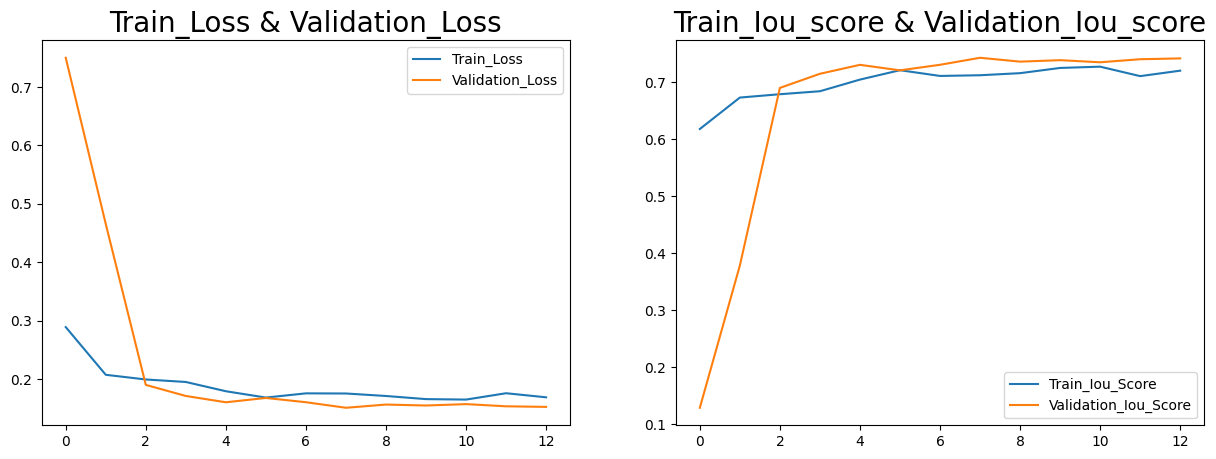

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

## Metrics

In [10]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe,transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.resize = [512, 512]
        self.class_size = 2
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['Image']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['Mask'],cv2.IMREAD_GRAYSCALE)
        aug = self.transforms_(image=img, mask=mask)            
        img, mask = aug['image'], aug['mask']
        img_view = np.copy(img)
        img = img/255
        img = self.pre_normalize(img)
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        mask_view = np.copy(mask)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target, 'img_view':img_view, 'mask_view':mask_view}
        return sample

test_dataset = TestDataset(val_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=4)

In [11]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.to(device)
def get_metrics(model, dataloder, threshold):
    IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
    batchs = 0
    model.eval()
    with torch.no_grad():
        for batch_i, batch in enumerate(dataloder):
            x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
            pred = model(x)
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)
            batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
            batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
            batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
            batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
            IoU_score += batch_iou_score
            acc += batch_acc
            f1_score += batch_f1_score
            recall += batch_recall
            precision += batch_precision
            batchs += 1
    IoU_score = round(IoU_score/batchs, 3)
    precision = round(precision/batchs, 3)
    f1_score = round(f1_score/batchs, 3)
    recall = round(recall/batchs, 3)
    acc = round(acc/batchs, 3)
    sample = {'iou':IoU_score, 'pre':precision, 'fi':f1_score, 're':recall, 'acc':acc}
    return sample
    
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]
for threshold in threshold_list:
    sample = get_metrics(model, test_loader, threshold)
    print(f"threshold: {str(threshold)} \
    IoU Score: {sample['iou']:.3f} \
    precision: {sample['pre']:.3f} \
    f1_score: {sample['fi']:.3f} \
    Recall: {sample['re']:.3f} \
    Acc: {sample['acc']:.3f}")




threshold: 0.3     IoU Score: 0.743     precision: 0.859     f1_score: 0.851     Recall: 0.855     Acc: 0.886
threshold: 0.4     IoU Score: 0.743     precision: 0.861     f1_score: 0.851     Recall: 0.852     Acc: 0.886
threshold: 0.5     IoU Score: 0.743     precision: 0.863     f1_score: 0.851     Recall: 0.850     Acc: 0.886
threshold: 0.6     IoU Score: 0.742     precision: 0.865     f1_score: 0.851     Recall: 0.848     Acc: 0.886
threshold: 0.7     IoU Score: 0.742     precision: 0.867     f1_score: 0.851     Recall: 0.846     Acc: 0.887


## Inference

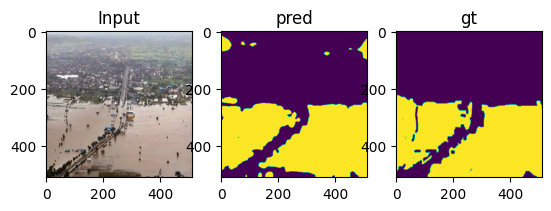

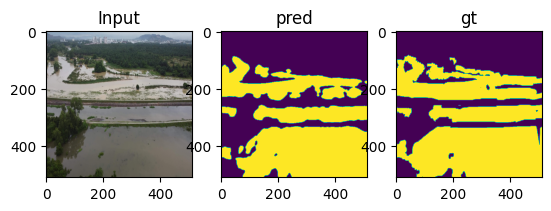

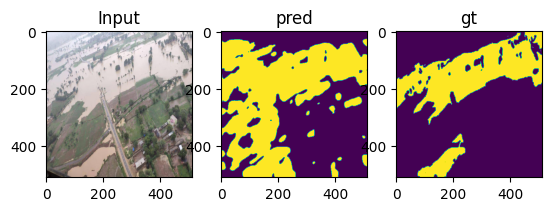

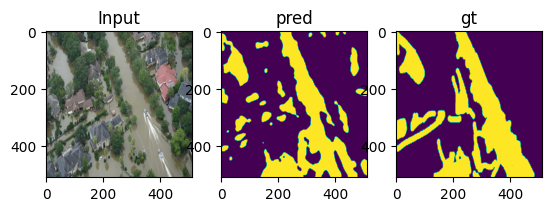

In [12]:
model.load_state_dict(torch.load("checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]
    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
    pred = pred.data.cpu().numpy()
    pred = np.where(pred<0.5, 0, 1).astype(np.int16)
    pred_img = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['img_view']
    img_view = Image.fromarray(img_view, 'RGB')
    
    mask_view = sample['mask_view']
    mask_view = Image.fromarray(mask_view, 'L')
                
    f, axarr = plt.subplots(1, 3) 
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(pred_img)
    axarr[1].set_title('pred')
    axarr[2].imshow(mask_view)
    axarr[2].set_title('gt')
    plt.show()

### If you find my code helpful, I would greatly appreciate your support through a vote. Feel free to engage in any discussions or provide suggestions—I welcome your input.